# EMIT Search

Brent Wilder


15 Nov 2024


In [1]:
import earthaccess
import xarray as xr
import requests
from io import BytesIO
from emit_tools import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage

# Log in to earthaccess
earthaccess.login(persist=True)

# User input below

In [2]:

#############################################################
# USER INPUTS #

# center of EMIT image you want to request
lat_center, lon_center = 46.852313, -121.758268

# list of tuples of pixel locations from the same image
# This could also be brought in from geopandas, etc...
coords = [(46.45, -121.75), (46.84, -121.76), (46.82, -121.76), (46.32, -121.76)]

#  save EMIT image to disk (replace with None if do not want to save)
emit_file_path = None

# Save csv (replace with None if do not want to save)
csv_file_path = './data/test.csv'

# USER INPUTS #
#############################################################





# Quickview

In [3]:
# run to get drop down menu
url_widget = get_image_selector(lat_center, lon_center)

Dropdown(description='Select Date:', options=(('2023-06-01T22:04:31.000Z', {'start_datetime': '2023-06-01T22:0…

Output()

Text(value='', description='PNG URL:', disabled=True, layout=Layout(width='100%'))

Text(value='', description='RFL URL:', disabled=True, layout=Layout(width='100%'))

### Now run the below chunk to load EMIT from earthaccess
NOTE: speed here depends on network and location. AWS(us-west-2) will be able to use S3direct links. For example, using slow WiFi speeds of 20 mbps, and on the east coast, it took 4-5 minutes to load. 

In [4]:
# open the file using earth access
file = earthaccess.open([url_widget[1].value])[0]
ds = emit_xarray(file,ortho=True)
if emit_file_path is not None:
    #write_envi(ds, emit_file_path, overwrite=True, extension='.img', interleave='BIL', glt_file=False)
    ds.to_netcdf(emit_file_path)
ds

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 6GB
Dimensions:           (latitude: 1806, longitude: 2739, bands: 285)
Coordinates:
    wavelengths       (bands) float32 1kB ...
    fwhm              (bands) float32 1kB ...
    good_wavelengths  (bands) float32 1kB ...
  * latitude          (latitude) float64 14kB 47.07 47.07 47.07 ... 46.09 46.09
  * longitude         (longitude) float64 22kB -122.7 -122.7 ... -121.2 -121.2
    elev              (latitude, longitude) float32 20MB -9.999e+03 ... -9.99...
    spatial_ref       int64 8B 0
Dimensions without coordinates: bands
Data variables:
    reflectance       (latitude, longitude, bands) float32 6GB -9.999e+03 ......
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.22715087e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        dummy_id
    Orthorectified:                    True

In [5]:
# Optional: if you just wanted to used the dynamic viewer, you could load in a netcdf here
#ds <- xr.open() etc..
#
#

# Subset spectra and plot

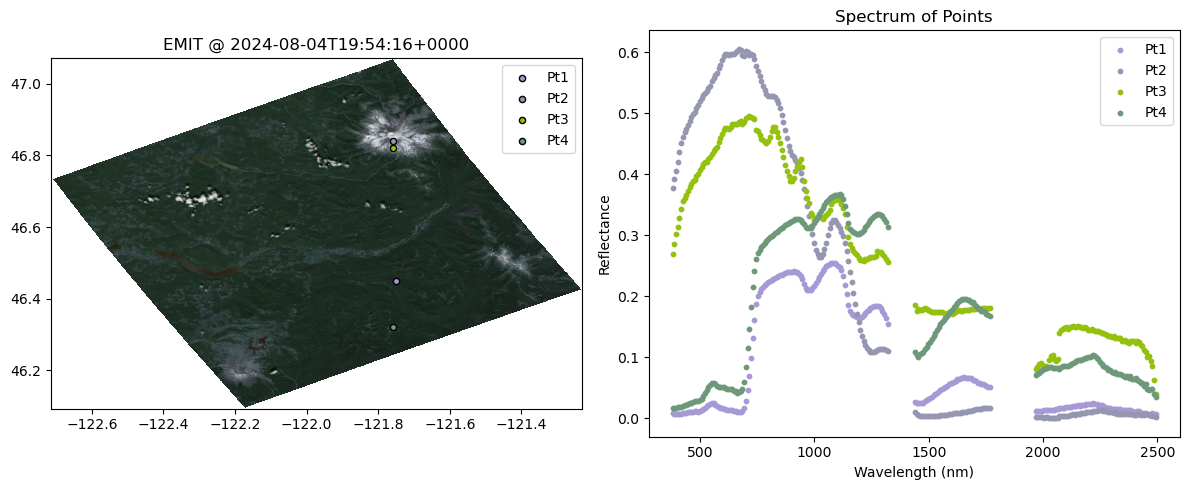

In [6]:
# Get spectra data from emit image
spectra_data = select_pixels(ds, coords)

# Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Extract reflectance data for plotting
reflectance = ds['reflectance']
rgb_image = reflectance.isel(bands=[11, 23, 34]).values
rgb_image_masked = np.ma.masked_equal(rgb_image, -9999)
rgb_image_eq = np.zeros_like(rgb_image_masked)
for i in range(3):
    channel = rgb_image_masked[:, :, i]
    channel = np.clip(channel, np.nanmin(channel), np.nanmax(channel)) 
    channel = skimage.exposure.rescale_intensity(channel, in_range=(0, 1))
    eq_channel = skimage.exposure.adjust_gamma(channel, gamma=0.5)
    rgb_image_eq[:, :, i] = eq_channel
rgb_image_eq[rgb_image == -9999] = np.nan
lat_min, lat_max = ds['latitude'].values.min(), ds['latitude'].values.max()
lon_min, lon_max = ds['longitude'].values.min(), ds['longitude'].values.max()
ax1.imshow(rgb_image_eq, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')

# Loop through each key and plot
for s_id, data in spectra_data.items():
    # Plot the selected pixel on the RGB image
    ax1.scatter(data['lon'], data['lat'], color=data['Color'], marker='o', s=20, edgecolor='k', label=s_id)
    ax2.scatter(data['Wavelength'], data['Reflectance'], color=data['Color'], s=10, label=s_id)

# Add legend and labels
ax1.legend()
ax1.set_title(f'EMIT @ {ds.time_coverage_start}')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Reflectance')
ax2.set_title('Spectrum of Points')
ax2.legend()
# Display the plots
plt.tight_layout()
plt.show()
#plt.savefig('./data/test.png', dpi=300)


# Save if specified...
if csv_file_path is not None:
    save_spectra_csv(spectra_data, csv_file_path)

# Dynamic viewing

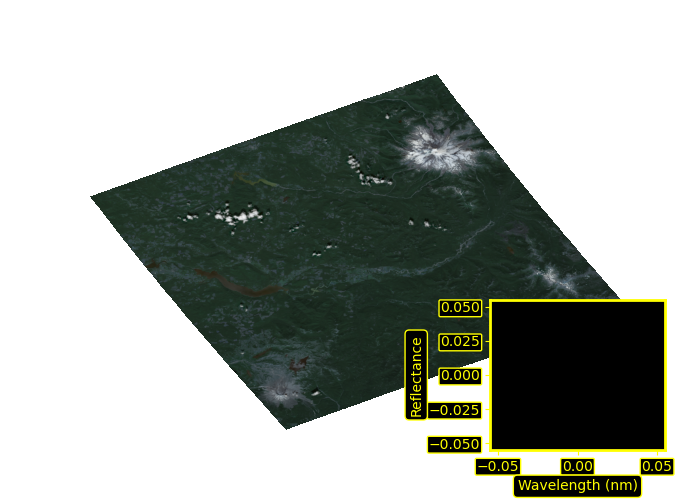

DataFrame saved to widget.


In [15]:
%matplotlib widget
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
wavelengths = ds['wavelengths'].values
df_widget = dynamic_plot(reflectance, latitudes, longitudes, wavelengths, rgb_image_eq)

# Display dataset you collected with dynamic viewer

In [16]:
df = df_widget.data_frame
df


# to save....
#df.to_csv(//your/path/here/)

,ID,lat,lon,Wavelength,Reflectance
0,Pt1,46.867273,-121.804407,381.005585,0.366680
1,Pt1,46.867273,-121.804407,388.409210,0.380406
2,Pt1,46.867273,-121.804407,395.815826,0.394467
3,Pt1,46.867273,-121.804407,403.225403,0.407718
4,Pt1,46.867273,-121.804407,410.638000,0.423688
...,...,...,...,...,...
2845,Pt10,46.507773,-122.236567,2463.381592,0.015028
2846,Pt10,46.507773,-122.236567,2470.767822,0.013941
2847,Pt10,46.507773,-122.236567,2478.153076,0.012748
2848,Pt10,46.507773,-122.236567,2485.538574,0.012750
